# 1  Automated data cleaning for chest Xrays with cleanX: notebook for medical professionals with limited coding abililties. 

CleanX is a code library by Candace Makeda Moore, MD, Oleg Sivokon, and Andrew Murphy. Please note this workflow does not cover the whole scope of cleanX, and is only meant to show some of the functionality that can be accomplished using cleanX. 

The purpose of this notebook is to educate people with very limited understanding of machine learning and code about some of what cleanX does, and why it is worth incorporating it into use. 

In [1]:
import sys
sys.path = ['D:/projects/cleanX'] + sys.path
# we will need to import some libraries
import pandas as pd
import os
from cleanX import (
    dataset_processing as csvp,
    dicom_processing as dicomp,
    image_work as iwork,
)

Reading and analysis of chest X-rays is a common task in hospitals. In fact in many hospitals so many chest X-rays are performed that some are never read, and some are only read by people with limited training in radiology. Some countries have a very limited number of radiologists so radiographers read the chest X-rays. Regardless of who reads these images, they can be difficult to interpret and the error rate is reported as high in the medical literature (over 10% or even over 15% depending upon the source). Machine learning based algorithms have the potential to improve this situation in a variety of ways, however machine learning algorithms are powered by mountains of labeled data. And this need for labeled data creates a potential problem. 

Labeled data must either be retrieved from existing read X-rays (errors included), or created by humans (already over-burdened with reading X-rays, actually that was the original problem in the first place, right?). Several groups have created big datasets that algorithms can be trained on, but no dataset is perfect for every task. Unfortunately many datasets contain images that may not be appropriate to make a machine learning algorithm from. As a case in point, let's take a look at some of the data in a large set of COVID-19 images. We will use the CoronaHack -Chest X-Ray-Dataset from Kaggle. The dataset was assembled by Praveen Govindaraj. This dataset has thousands of images...too many to look through by hand without wasting a lot of time

In [2]:
origin_folder ='D:/my_academia/ncs/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/'

## Finding duplicates
We may or may not want to use duplicated images to build an algorithm. Generally, it's a bad idea. At the extreme, if all of one pathology is simply duplicated images, we do not have enough data. Instead of trying to remember if we see duplicates in thousands of images, let's ask cleanX. cleanX compares the images pixel by pixel, and this takes time if you don't have a powerful computer, but it doesn't take human time. We can take a much needed break! 

In [3]:
found = iwork.find_duplicated_images_todf(origin_folder)
len(found[found.status == 'duplicated'])  

26

OK, so we may have 26 duplicates. Not so bad out of thousands of pictures. Let's pull up a list so we can check them by hand.

In [4]:
found[found.status == 'duplicated']

,images,status
5287,NORMAL2-IM-0587-0001-0002.jpeg,duplicated
5288,person1159_virus_1945.jpeg,duplicated
5289,person124_virus_247.jpeg,duplicated
5290,person1261_virus_2148.jpeg,duplicated
5291,person1312_bacteria_3318.jpeg,duplicated
5292,person1343_bacteria_3414.jpeg,duplicated
5293,person1349_bacteria_3437.jpeg,duplicated
5294,person1372_bacteria_3502.jpeg,duplicated
5295,person1372_bacteria_3503.jpeg,duplicated
5296,person1430_bacteria_3696.jpeg,duplicated


In [5]:
wierd_images = found[found.status == 'duplicated']
wierd_images_list = wierd_images.images.to_list()

# we need the full file path
final_names = []
for image_string in wierd_images_list:
    final_names.append(os.path.join(origin_folder, image_string))

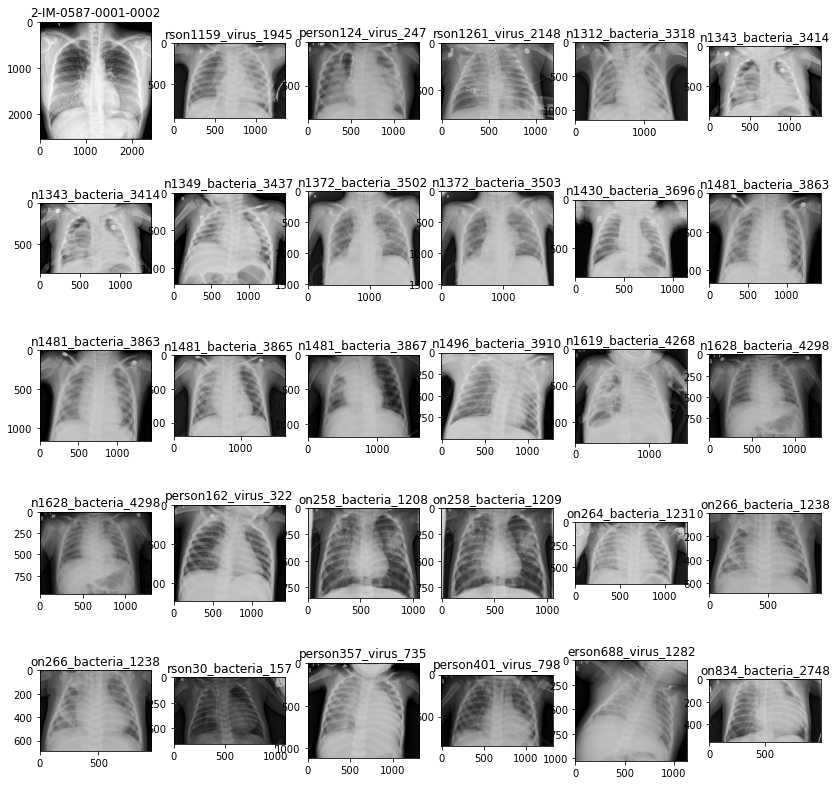

In [6]:
iwork.show_images_in_df(final_names,19)

In [7]:
# make a function that compares one image to list, and finds closest. 
import cv2
import numpy as np
image1 = 'person1372_bacteria_3502.jpeg'
image1name = os.path.join(origin_folder, image1)
compare_list = final_names
image1image = cv2.imread(image1name)
results = []
pictures = []
width, height = image1image.shape[1], image1image.shape[0]
dim = (width, height)
for picture in compare_list:
    
    image_there = cv2.imread(picture)
    resized = cv2.resize(image_there, dim, interpolation = cv2.INTER_AREA)
    result = resized - image1image
    result_sum = np.sum(result)
    results.append(result_sum)
    pictures.append(pictures)

In [ ]:
d = {'results':results,'pictures':pictures}
ho = pd.DataFrame(d)

In [ ]:
ho

Interesting, some of our duplicated pictures appear to have been triplicated, and we get two of the same duplicate.

## Finding outlier images

Now let's move on to seeing if we really have all similarly shot chest Xrays, or some nonsense flew in. We can use one of several methods with cleanX:

In [ ]:
# in a chest Xray we expect more white on top- the abdomen is bigger than the neck, let's see where that is not true
upper_lower_returned = iwork.find_sample_upper_greater_than_lower(origin_folder, 10)
# let's look at a sample of upper part of images and see if there are outliers
upper_scan_returned = iwork.find_by_sample_upper(origin_folder, 10, 200)
#let's compare each image to an average of all images, and take the most different
tiny_image_different = iwork.find_tiny_image_differences(origin_folder, percentile=1)